# Deep Learning Project : FashioNet

In [2]:
# Exécutez cette cellule pour installer votre Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Pour accélérer la GPU

In [1]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 
#https://medium.com/@oribarel/getting-the-most-out-of-your-google-colab-2b0585f82403

  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.9 GB  | Proc size: 150.6 MB
GPU RAM Free: 15079MB | Used: 0MB | Util   0% | Total 15079MB


In [0]:
!kill -9 -1
#https://medium.com/@oribarel/getting-the-most-out-of-your-google-colab-2b0585f82403

## Personal fashion expert and shopping companion

## By : Plaban Mohanty - pm2878  &   Aliraza Punjani -  amp2280

#### Objectives :

In FashioNet we aim to build a fashion recommendation system capable of learning a person’s clothing style and preferences by extracting the a variety of attributes from his/her clothing images. These attributes are then fed to a similarity model to retrieve most closest similar images as recommendations.


#### Approach:
We planned to train a convolutional deep net, capable of performing multi-class, multi-label classification. So each clothing article can have one or more clothing attributes attached to it, with each attribute itself having classes. We decided to go for attributes like Pattern [checkered, striped, floral, graphic, solid], Fabric [cotton, chiffon, lace, wool, silk] , Style [casual, formal, party, winter, summer], Shape [full-sleeve, half-sleeve, sleeveless] . For each clothing image the network would output, what we’d like to call, a Fashion Vector. A Fashion Vector is basically a vector with attributes as the dimensions and the attribute class as the value. It’d look like [attribute1_class, attribute2_class, attribute3_class, ...]
[checkered, cotton, formal, ...]. 
These fashion vectors will be used to create a similarity model to provide recommendations.

#### Attempted Models:
We planned to use domain transfer to cut down on training time. The dataset that we initially used was DeepFashion database. This database comprised of more than 60k images that belonged to over 1000 attributes.
We began with testing out the dataset on a modified VGG architecture with a dense output layer of 1000 neurons. Given such large number of attributes, there was a lot of sparsity in the data. This meant the network had no incentive to predict presence of an attribute and rather just marked all attributes as absent. To tackle this class imbalance we had to incorporate a customized weighted loss. To implement weighted loss in keras we had to use Graph model with a shared backbone and 1000 output layer with 1 neuron each. The model was penalized comparatively more for misclassifying class 1 than 0 for each attribute. However, the sparsity and class imbalance was too high to be managed by weighted loss. The network stalled on about 30% validation accuracy and wouldn’t train further. We decide to construct our own database and modify the network architecture to fit the new dataset.


#### Dataset : 
The final dataset that we used was comprised of about 50000 images that we collected from the internet by scraping the web and various clothing retail sites. The dataset collected was highly specific to train our models . We listed the specific features required to form our feature vector and extracted images specific to the classes of this features. 
 We invested heavily on data preprocessing so that the network would not have any data specific issues. We did a automated curating and cleaning of data to eliminate duplicates and non relevant images. We then did a manual check to eliminate images that were not specific to the class they were meant to belong to for training. We ran the data sets on simple neural networks to check if they performed well enough to be used in the main model. 
Once we were satisfied with the performance , we used the images as the training and validation dataset and separated out a well represented section for test. (7:1.5:1.5)
 

#### Implementation
 
To implement the proposed model , we needed to build models to initially classify the categories of features . Using these models, we form the fashion vector i.e a vector with all categories of features classified for each image . With these vectors ,w
e build a style profile for a user based on the input images . We match this profile with fashion vectors of images in repository to form the best suited recommendations
 
##### a.    Network architecture
 
We use Keras wrapper for tensorflow and VGG16 model as the base of the network.
The base of our network is VGG16. On top of the network , we add a customized dense layer of 512 neurons with RELU activation. For the final classification, we use a softmax layer of n output neurons where n is the no of subclasses for each category of feature
We use pre-trained VGG16 model on ImageNet as the starting weights / parameters .
 
Now, we build m such networks , each to train one category of feature (where m is the total no of categories of features , 5 in our case) and use a stacked version of these networks .
 
With this stacked CNNs , each input image entered is classified into one of the classes for each category , these classifications are then combined to form a Fashion Vector for that image
 
##### b.   Training
 
As we are performing domain transfer, we freeze the bottom layers of the network i.e the VGG16 layers and train the model on the dataset for 5 epochs .This trains the outer layers to learn to classify the images.
We then unfreeze the lower layers and train the model for 5-7 epochs until the validation accuracy stabilizes.
We store the best possible weights (best on validation accuracy) and use it for the recommendation model.
 
##### c.   Repository Creation
 
To get recommendations ,we needed to build a repository of images . This repository would be application specific .If the recommendation needs to be done for shopping , then the repository would contain images from online retail stores like Amazon,Macy’s etc. We used images scraped from these stores and added scraped images from the web to test our recommendation engine.
We then cleaned the data , and removed the images which were not relevant /noise.
The images were then passed through the network and fashion images were generated from each image .All these vectors were combined to form the repository.
 
##### d.  Recommendation Model
For the recommendation ,we first need to construct the user style profile . This is done by taking one or more images of the user’s preferred clothing items as input and creating their fashion vector . These vectors are then combined to form the style profile matrix of a person .

Now we use a similarity algorithm to compare the fashion vector of each image in the repository with the style profile matrix . This gives us a score based on the number of feature matches - the higher the score the closer an image is to the person’s style profile.

We then rank the images in order of their scores and display the top most images as recommendations


### Contribution : 

As we tried out multiple architectures and analysed performance over multiple datasets, the work was quite fairly split doing research, implementation and testing out models. 

While testing out the initial architecture , I analysed the problem and found it to be a  multi class multi labeled classification problem. So I built a VGG-16 based CNN with a single output layer with 1000 neurons with a sigmoid function as activation. I tested the model with a binary cross entropy loss and used the DeepFashion dataset to check the performance . The performance was not satisfactory and hence I modified the network to make it work better for multi label classification .I designed a new loss function with the Keras API , employing the tensor operations to succesfully compute weighted loss on multi label classification results. This custom loss function that I designed was made to work for the case of sparse data and utilised higher weights to back propagate the error in predicting a 0 instead of 1 for any of the labels. While there was improvement , it was not significant and hence I discussed and decided to craft a new dataset and a different model.

We discussed the model architectures and came up with a plan of stacked CNNs for the primary FashionNet model. As we had extracted the most important features from the previous designs and had classified them into classes , we split the work of training each CNN for  each class. 

For this ,we discussed and formed a plan of data collection and steps for preprocessing and cleaning . I took up the features for Pattern (Checked, Striped etc) and Style (Business, Casuals, Partywear etc. ) . I extracted images from the web specific to the distributions of these feature classes. After extensive preprocessing and cleaning of data as mentioned above, I constructed the model of stacked CNN to predict the features specific to these classes of attributes . I trained the models with the data set to generate predictions that were fairly accurate and were able to accurately predict almost all forms of images.

With my teammate training the other half of the feature classes , we compiled them together to form the model of stacked CNNs to craft the fashion vector. 
I designed the recommender system by formulating a similarity score measure from the fashion vectors . This system would form the input vector based on the images entered by the user of his preferred clothes and compare the input vector with each vector in the repository. The score system as can be seen in the code below employs a unique algorithm customised to work in this network.
We then separately scraped data for use in the repository of images for recommendation and carried out the image preprocessing steps for these as well. 
After having the fashion vectors for all these images , we compiled the model to build the recommendation engine that would extract the most useful recommendations from the repository 

## Code

In [3]:
import os
import h5py
import operator

import matplotlib.pyplot as plt
import time, pickle, pandas

import numpy as np

from tensorflow import keras
import tensorflow as tf
from PIL import Image
import glob

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D ,Conv2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras import backend
from keras import optimizers
from keras import applications

%matplotlib inline

Using TensorFlow backend.


In [0]:
!pip install -q keras

In [0]:
import keras

In [0]:
!apt-get install graphviz -y

In [0]:
! nvidia-smi


In [4]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
from tensorflow.python.client import device_lib
print (device_lib.list_local_devices())

#https://towardsdatascience.com/build-your-own-robust-deep-learning-environment-in-minutes-354cf140a5a6

## Training the model for one category of features

We train the model to classify the apparel images to one class of the category taken. We repeat this process to get multiple models ,each corresponding to a category of features that we want to use. 
Currently we use four major categories - pattern,fabric,style,part along with color to form the Fashion Vector. So we train 5 models using the below mentioned process

For sake of keeping this report concise , we present the running model along with results for one particular category :
- Pattern 

In [0]:
# Declaring the no of classes for the category
nb_classes = 3
class_name = {
    0: 'Manches_courtes',
    1: 'Manches_longues',
    2: 'Manches_sans'
}

In [0]:
#Afficher dans quelle classe 0,1,2,3,4
def show_sample(X, y, prediction=-1):
    #Image X
    im = X
    #Montrer image im
    plt.imshow(im)
    if prediction >= 0: 
        #Titre : class_name[y] = clé ?? et class_name[prediction] = clé ??
        plt.title("Class = %s, Predict = %s" % (class_name[y], class_name[prediction]))
    else:
        plt.title("Class = %s" % (class_name[y]))

    plt.axis('on')
    plt.show()

### Importer et Spliter en train, test, validation avec % selon les 5 classes pour chacun

### Train & Validation data 


In [0]:
#ATTENTION OMG !!!!!!!!!!!!!!!!!!!!!!!!!!
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')



In [7]:
!ls "/content/drive/My Drive/Colab Notebooks"

'Copie de FashionNet_Shape.ipynb'   vgg16_weights.h5
 FashionNet_Shape.ipynb		    vgg16_weights_th_dim_ordering_th_kernels.h5
 train				    vgg_weights_best_shape.h5
 val				    vgg_weights_frozen_shape.h5


In [0]:
# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = '/content/drive/My Drive/Colab Notebooks/train' #change dir to your project folder
validation_data_dir = '/content/drive/My Drive/Colab Notebooks/val' #change dir to your project folder

We have already separated the data into train and validation and kept it in the “train” and “validation” folders. We can use ImageDataGenerator available in Keras to read images in batches directly from these folders and optionally perform data augmentation. We will use two different data generators for train and validation folders

In [9]:
from keras.preprocessing.image import ImageDataGenerator
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(rescale=1./255)

# this is the augmentation configuration we will use for testing:
#explanation of parameters :https://towardsdatascience.com/https-medium-com-manishchablani-useful-keras-features-4bac0724734c
from keras.preprocessing.image import ImageDataGenerator 

test_datagen = ImageDataGenerator(rescale=1./255)
## this is the augmentation configuration we will use for training
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=50,
        class_mode='categorical')
#
# this is the augmentation configuration we will use for testing
validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=50,
        class_mode='categorical')


Found 5250 images belonging to 3 classes.
Found 1314 images belonging to 3 classes.


In [0]:
nb_train_samples = 5250
nb_validation_samples = 1314

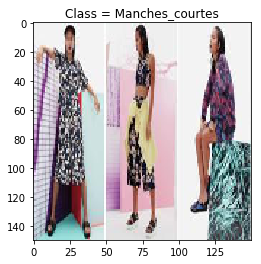

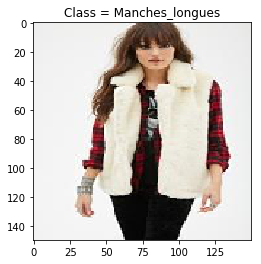

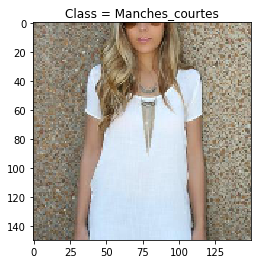

In [11]:
#def show_sample(X, y, prediction=-1)
#batch = lots
import PIL
from PIL import Image
from IPython.display import display

#X et Y in train
for X_batch, Y_batch in train_generator:
    for i in range(3): #changer ici 5 en 3 pour shape
        #show_sample(X, y, prediction=-1)
        show_sample(X_batch[i, :, :, :], np.argmax(Y_batch[i]))
    break

### Modeling 

In [12]:
#defining the fully connected layer: Model VGG16
def build_vgg16(framework='tf'):

    if framework == 'th':
        # build the VGG16 network in Theano weight ordering mode
        backend.set_image_dim_ordering('th')
    else:
        # build the VGG16 network in Tensorflow weight ordering mode
        backend.set_image_dim_ordering('tf')
        
    model = Sequential()
    if framework == 'th':
        model.add(ZeroPadding2D((1, 1), input_shape=(3, img_width, img_height)))
    else:
        model.add(ZeroPadding2D((1, 1), input_shape=(img_width, img_height, 3)))
        
    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    #model.add(MaxPooling2D((2, 2),padding='same', strides=(2, 2))) #padding='same' à ajouter pour faire tourner le train..epoch
  
        
    return model


# Download weights
#pip install :https://modelzoo.co/model/alexnet-vgg-16-vgg-19-and
#pip install --user cython h5py
#pip install Theano

#load the ImageNet pre-trained weight : https://blog.heuritech.com/2016/04/26/pre-trained-convnets-and-object-localisation-in-keras/
#weights_path = 'vgg16_weights.h5'

##https://github.com/fchollet/deep-learning-models/releases/tag/v0.1 : download vgg16_weights_th_dim_ordering_th_kernels.h5
#th_model >>> Theano ""...th_dim_ordering"
weights_path = '/content/drive/My Drive/Colab Notebooks/vgg16_weights.h5' 


#Load VGG16 network in Theano weight
th_model = build_vgg16('th')

#Set weight in Theano th_model
assert os.path.exists(weights_path)

f = h5py.File(weights_path)
for k in range(len(f.attrs["layer_names"])): #range(0, 22)
    if k >= len(th_model.layers) or k == 0 : #cf cellule ci-dessous
        # we don't look at the last (fully-connected) layers in the savefile
        break
    g = f['layer_{}'.format(k)]
    weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
    th_model.layers[k].set_weights(weights)
    f.close()
print('Model loaded.')


#Load  VGG16 network in Tensorflow weight
tf_model = build_vgg16('tf')


#Set weight in tf_layers
for th_layer, tf_layer in zip(th_model.layers, tf_model.layers):
    if th_layer.__class__.__name__ == 'Convolution2D':
      kernel, bias = th_layer.get_weights()
      kernel = np.transpose(kernel, (2, 3, 1, 0))
      tf_layer.set_weights([kernel, bias])
    else:
      tf_layer.set_weights(tf_layer.get_weights())


# Define model : fully-connected layers
top_model = Sequential()
print (Flatten(input_shape=tf_model.output_shape[1:]))

#top_model = tf_model 
top_model.add(Flatten(input_shape=tf_model.output_shape[1:]))
top_model.add(Dense(512, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(3, activation='softmax'))#changer ici 5 en 3 pour shape
tf_model.summary()
top_model.summary()
'''The base of our network is VGG16. On top of the network , we add a customized 
dense layer of 512 neurons with RELU activation. 
For the final classification, we use a softmax layer of n output neurons where n 
is the no of subclasses for each category of feature.

We use pre-trained VGG16 model on ImageNet as the starting weights / parameters'''

#pour afficher la colonne connect : dernière version de keras :
#https://inmachineswetrust.com/posts/deep-learning-setup/
#output in TF 1.12 has the connected to column

W0628 00:41:23.932522 139946223314816 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0628 00:41:23.939933 139946223314816 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="conv1_1")`
  app.launch_new_instance()
W0628 00:41:23.958537 139946223314816 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0628 00:41:23.972197 139946223314816 deprecation_wrapper.py:119] From /usr/

Model loaded.


W0628 00:41:32.760012 139946223314816 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_14 (ZeroPaddi (None, 152, 152, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 150, 150, 64)      1792      
_________________________________________________________________
zero_padding2d_15 (ZeroPaddi (None, 152, 152, 64)      0         
_________________________________________________________________
conv1_2 (Conv2D)             (None, 150, 150, 64)      36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 75, 75, 64)        0         
_________________________________________________________________
zero_padding2d_16 (ZeroPaddi (None, 77, 77, 64)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 75, 75, 128)       73856     
__________

'The base of our network is VGG16. On top of the network , we add a customized \ndense layer of 512 neurons with RELU activation. \nFor the final classification, we use a softmax layer of n output neurons where n \nis the no of subclasses for each category of feature.\n\nWe use pre-trained VGG16 model on ImageNet as the starting weights / parameters'

### Add the model to the top model

In [0]:
# add the TensorFlow tf_model on top of the convolutional base
tf_model.add(top_model) 

In [0]:
#Freezing the weights of all layers except top

for layer in tf_model.layers[:-4]:
    layer.trainable = False #Trained #True = Fro

    # Check the trainable status of the individual layers
for layer in tf_model.layers:
    print(layer, layer.trainable)


#Using an Adam optimizer with lower learning rate
adam1=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#sgd = optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
tf_model.compile(loss = 'categorical_crossentropy',
              optimizer = adam1,
              metrics=['accuracy'])
# So, set by setting 'trainable' to False you are freezing those layers and they wont get trained.

After the FC layers have had a chance to warm up we may choose to unfreeze  ***all***  layers in the network and allow each of them to be ﬁne-tuned as well.

In some cases, we may never unfreeze the body of the network as our 
new FC head may obtain sufﬁcient accuracy.

After the FC head has started to learn patterns in our dataset, 
pause training, unfreeze the body, and then continue the training, 
but with a very small learning rate – we do not want to deviate our 
CONV ﬁlters dramatically. Training is then allowed to continue until 
sufﬁcient accuracy is obtained.

[Adrian_Rosebrock]_Deep_Learning_for_Computer_Visi

### Train and Save weights

In [0]:
#tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)
#ModelCheckpoint: https://keras.io/applications/
checkpoint_callback = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/vgg_weights_frozen_shape.h5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', period=1)

batch_size=50
#Step 4
#use these DATA generators to train our model 
tf_model.fit_generator(
        train_generator,
        steps_per_epoch= nb_train_samples // batch_size, #for Keras 2 : https://github.com/keras-team/keras/issues/11603
        nb_epoch = 50,
        validation_data = validation_generator,
        validation_steps= nb_validation_samples // batch_size, #// integer division return an integer
        verbose = 1,
        initial_epoch = 0,
        callbacks=[checkpoint_callback]
)




# always save your weights after training or during training
tf_model.save_weights('/content/drive/My Drive/Colab Notebooks/vgg_weights_frozen_shape.h5')
print("Saved model to disk")



In [0]:
#validation_generator : X_batch, Y_batch

accuracies = np.array([])
losses = np.array([])

i=0
for X_batch, Y_batch in validation_generator:
    loss, accuracy = tf_model.evaluate(X_batch, Y_batch, verbose=0)
    losses = np.append(losses, loss)
    accuracies = np.append(accuracies, accuracy)
    i += 1
    if i == 20:
        break
       
    print ("Validation: accuracy = %f  ;  loss = %f" % (np.mean(accuracies), np.mean(losses)))

In [15]:
#unfreezing the layers and recompiling the model 

for layer in tf_model.layers[:-4]:
    layer.trainable = True #False : freeze
    
#Check the trainable status of the individual layers
for layer in tf_model.layers:
    print(layer, layer.trainable)    
  
#Using an Adam optimizer with lower learning rate
adam1=optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
tf_model.compile(loss = 'categorical_crossentropy',
              optimizer = adam1,
              metrics=['accuracy'])

# So, set by setting 'trainable' to false you are freezing those layers and they wont get trained.
#with unfreezing more layers, progressively from the top.

W0628 00:44:45.081794 139946223314816 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



<keras.layers.convolutional.ZeroPadding2D object at 0x7f475f7943c8> True
<keras.layers.convolutional.Conv2D object at 0x7f475f794710> True
<keras.layers.convolutional.ZeroPadding2D object at 0x7f475f794be0> True
<keras.layers.convolutional.Conv2D object at 0x7f475f794908> True
<keras.layers.pooling.MaxPooling2D object at 0x7f475f794080> True
<keras.layers.convolutional.ZeroPadding2D object at 0x7f475f7e0908> True
<keras.layers.convolutional.Conv2D object at 0x7f475f78cc18> True
<keras.layers.convolutional.ZeroPadding2D object at 0x7f475f7e00f0> True
<keras.layers.convolutional.Conv2D object at 0x7f475f780748> True
<keras.layers.pooling.MaxPooling2D object at 0x7f475f780550> True
<keras.layers.convolutional.ZeroPadding2D object at 0x7f475f7d9940> True
<keras.layers.convolutional.Conv2D object at 0x7f475f7d93c8> True
<keras.layers.convolutional.ZeroPadding2D object at 0x7f475f7d9e80> True
<keras.layers.convolutional.Conv2D object at 0x7f475f7cec88> True
<keras.layers.convolutional.ZeroPa

In [0]:
#Loading weights with the best validation aaccuracy
tf_model.load_weights('/content/drive/My Drive/Colab Notebooks/vgg_weights_frozen_shape.h5')

In [0]:
#Training the whole network for 50 epochs 
checkpoint_callback = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/vgg_weights_best_shape.h5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

batch_size = 50
tf_model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        nb_epoch = 60, 
        validation_data = validation_generator,
        validation_steps=nb_validation_samples // batch_size,
        verbose = 1,
        initial_epoch = 50,
        callbacks=[checkpoint_callback]
)



# always save your weights after training or during training
tf_model.save_weights('/content/drive/My Drive/Colab Notebooks/vgg_weights_best_shape.h5')
print("Saved model to disk")

#probleme d'accuracy : https://www.learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/

In [0]:
accuracies = np.array([])
losses = np.array([])

i=0
for X_batch, Y_batch in validation_generator:
    loss, accuracy = tf_model.evaluate(X_batch, Y_batch, verbose=0)
    losses = np.append(losses, loss)
    accuracies = np.append(accuracies, accuracy)
    i += 1
    if i == 20:
        break
       
    print("Validation: accuracy = %f  ;  loss = %f" % (np.mean(accuracies), np.mean(losses)))

In [0]:
#Loading weights with the best validation aaccuracy
tf_model.load_weights('/content/drive/My Drive/Colab Notebooks/vgg_weights_best_shape.h5')

In [17]:
checkpoint_callback = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/vgg_weights_best_shape2.h5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

batch_size = 50
tf_model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        nb_epoch = 75,
        validation_data = validation_generator,
        validation_steps=nb_validation_samples // batch_size,
        verbose = 1,
        initial_epoch = 70,
        callbacks=[checkpoint_callback]
)


tf_model.save_weights('/content/drive/My Drive/Colab Notebooks/vgg_weights_best_shape2.h5')
print("Saved model to disk")



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=105, validation_data=<keras_pre..., validation_steps=26, verbose=1, initial_epoch=70, callbacks=[<keras.ca..., epochs=75)`
  if sys.path[0] == '':
W0628 00:46:24.039808 139946223314816 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapp

Epoch 71/75
105/105 [==============================] - 1759s 17s/step - loss: 0.1770 - acc: 0.9360 - val_loss: 0.8000 - val_acc: 0.7777
Epoch 72/75
105/105 [==============================] - 48s 462ms/step - loss: 0.1230 - acc: 0.9571 - val_loss: 1.1216 - val_acc: 0.7777
Epoch 73/75
105/105 [==============================] - 46s 443ms/step - loss: 0.1167 - acc: 0.9592 - val_loss: 1.0162 - val_acc: 0.7737
Epoch 74/75
105/105 [==============================] - 47s 446ms/step - loss: 0.1016 - acc: 0.9634 - val_loss: 1.1092 - val_acc: 0.7595
Epoch 75/75
105/105 [==============================] - 47s 444ms/step - loss: 0.1198 - acc: 0.9583 - val_loss: 0.8749 - val_acc: 0.7927
Saved model to disk


Now the best model for pattern is saved in an hdf5 file. We do a similar run for all the categories of features and get models for each of those. 

Once we have the models , we now start the process of generating the repository of images and getting inputs to form the style profile. After that we use that to get recommendations based on a similarity model

## Generating Recommendations - Recommendation Model 

 Initialising the categories of features and the subclasses for each category

In [0]:

class_part = {
    0: 'FullSleeve',
    1: 'HalfSleeve',
    2: 'Sleeveless'}
class_pattern = {
    0: 'Checked',
    1: 'Floral',
    2: 'Graphic',
    3: 'Plaid',
    4: 'Striped'}
class_fabric = {
    0: 'Cotton',
    1: 'Crochet',
    2: 'Denim',
    3: 'Silk',
    4: 'Wool'}
class_color = {
    0: 'Black',
    1: 'Blue',
    2: 'Green',
    3: 'Red',
    4: 'White'}
class_style = {
    0: 'Casual',
    1: 'Formal',
    2: 'Party',
    3: 'Summer',
    4: 'Winter'}

Function to display images

In [0]:
def show_sample(X):
    im = X
    plt.imshow(im)
    
    plt.axis('on')
    plt.show()

All the images to form the repository are in the folder "images" . These images are taken from online retail sites for shopping recommendation . It could be taken from web scraping for other applications as well

In [0]:
img_width, img_height = 150, 150

imagelist = []
# top_model_weights_path = 'bottleneck_fc_model.h5'
image_data_dir = 'images/'
#chosenOnes = sorted(os.listdir(train_data_dir))
count = 0

test_datagen = ImageDataGenerator(rescale=1./255)

data1_generator = test_datagen.flow_from_directory(
        image_data_dir,
        target_size=(150, 150),
        batch_size=1,
        class_mode=None,
        shuffle = False)






In [0]:
# Reshaping the images array
nb_data_samples = 9234
c=0
images_valid=[]
for X_batch in data1_generator:
    c+=1
    if (c>nb_data_samples):
        break
    images_valid.append(X_batch[0,:,:,:])
    

data_images=np.asarray(images_valid)
print (data_images.shape)
#np.save("last_resort.npy",np.asarray(imagelist,dtype=np.uint8))

Loading all the models previously trained and saved

In [0]:
pattern_model = load_model('./models/model_pattern_final.hdf5')
fabric_model = load_model('./models/model_fabric_final.hdf5')
color_model = load_model('./models/model_color_final.hdf5')
style_model = load_model('./models/model_style_final.hdf5')
part_model = load_model('./models/model_part_final.hdf5')
#part_model = load_model('my_model.h5')

Predicting the category features for images in repository

In [0]:
pattern=pattern_model.predict(data_images)
fabric=fabric_model.predict(data_images)
color=color_model.predict(data_images)
style=style_model.predict(data_images)
part=part_model.predict(data_images)
print ("Pattern : " , pattern.shape)
print ("fabric : " , fabric.shape)
print ("color : " , color.shape)
print ("Style : " , style.shape) 
print ("Part : " , part.shape)

Showing predictions for 5 random images in repository

In [0]:
for i in range(10,15):
    
    #show_sample(data_images[i])
    print ("Pattern : " , class_pattern[np.argmax(pattern[i])])
    print ("Fabric : " , class_fabric[np.argmax(fabric[i])])
    print ("Color : " , class_color[np.argmax(color[i])])
    print ("Style : " , class_style[np.argmax(style[i])])
    print ("Part : " , class_part[np.argmax(part[i])])
    show_sample(data_images[i])
    print ("---------------------------------------------")

### Creating the fashion vector for images in repository

In [0]:
feature_list=[]
for i in range(len(data_images)):
    vals=np.zeros(5)
    vals[0] = np.argmax(pattern[i])
    vals[1] = np.argmax(fabric[i])
    vals[2] = np.argmax(color[i])
    vals[3] = np.argmax(style[i])
    vals[4] = np.argmax(part[i])
    feature_list.append(vals)
    
print (feature_list[3])
feature_data = np.asarray(feature_list)
print (feature_data.shape)
#np.save("db_images.npy",data_images)
#np.save("db_features.npy",feature_data)

## Getting input vectors

Input images i.e images of user with preferred clothes that would be used to form the style profile of that user is stored in input folder

In [0]:
image_input_dir = 'input/'
inpdata_generator = test_datagen.flow_from_directory(
        image_input_dir,
        target_size=(150, 150),
        batch_size=1,
        class_mode=None,
        shuffle = False)


### Creating the input fashion vector

In [0]:
nb_input_samples = 2
c=0
images_input=[]
for X_batch in inpdata_generator:
    c+=1
    if (c>nb_input_samples):
        break
    images_input.append(X_batch[0,:,:,:])
    

data_images_inp=np.asarray(images_input)
print (data_images_inp.shape)

In [0]:
inp_pattern=pattern_model.predict(data_images_inp)
inp_fabric=fabric_model.predict(data_images_inp)
inp_color=color_model.predict(data_images_inp)
inp_style=style_model.predict(data_images_inp)
inp_part=part_model.predict(data_images_inp)
print ("Pattern : " , inp_pattern.shape)
print ("Fabric : " , inp_fabric.shape)
print ("Color : " , inp_color.shape)
print ("Style : " , inp_style.shape) 
print ("Part : " , inp_part.shape) 

#### Showing the input images with predicted values

In [0]:
for i in range(len(data_images_inp)):
    print ("Pattern : " , class_pattern[np.argmax(pattern[i])])
    print ("Fabric : " , class_fabric[np.argmax(fabric[i])])
    print ("Color : " , class_color[np.argmax(color[i])])
    print ("Style : " , class_style[np.argmax(style[i])])
    print ("Part : " , class_part[np.argmax(part[i])])
    show_sample(data_images_inp[i])

In [0]:
inp_feature_list=[]
for i in range(len(data_images_inp)):
    vals=np.zeros(5)
    vals[0] = np.argmax(inp_pattern[i])
    vals[1] = np.argmax(inp_fabric[i])
    vals[2] = np.argmax(inp_color[i])
    vals[3] = np.argmax(inp_style[i])
    vals[3] = np.argmax(inp_part[i])
    inp_feature_list.append(vals)
    
inp_feature_data = np.asarray(inp_feature_list)
print (inp_feature_data.shape)

### Similarity Function

In [0]:
def similarity(feature_data,inp_feature_data):
    num_samp=inp_feature_data.size
#     print (num_samp)
    sim_score={}
    for i in range(len(feature_data)):
        score=0
#         show_sample(data_images[i])
#         print(feature_data[i])
        score_m= inp_feature_data - feature_data[i]
#         print (score_m)
        score = num_samp-np.count_nonzero(score_m)
        sim_score[i]=score
#         print (score)
    
    return sim_score


In [0]:
similarities=similarity(feature_data,inp_feature_data)
sorted_similarities = sorted(similarities.items(), key=operator.itemgetter(1),reverse=True)
#print (sorted_similarities)
num_reco=30
num_data=feature_data.size
for i in range(num_reco):
    ind = sorted_similarities[i][0]
    print("Score : ", sorted_similarities[i][1])
    show_sample(data_images[ind])


## Citations 

1. Ziwei Liu, Ping Luo, Shi Qiu, Xiaogang Wang, and Xiaoou Tang  , DeepFashion: Powering Robust Clothes Recognition and Retrieval with Rich Annotations , June 2016
2. Yann LeCun, Yoshua Bengio  and Geoffrey Hinton , Deep learning , 2015
3. Karen Simonyan & Andrew Zisserman , Very deep convolutional networks for large scale image recognition , 2015
4. Bell, S., Upchurch, P., Snavely, N., and Bala, K. Material recognition in the wild with the materials in context database. CoRR, abs/1412.0623, 2014.
5. Chatfield, K., Simonyan, K., Vedaldi, A., and Zisserman, A. Return of the devil in the details: Delving deep into convolutional nets. In Proc. BMVC., 2014